# Pneumonia Identification from X-rays

Data available at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810

#### Import the necessary Libraries 

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os

In [2]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12880410839884542673
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3665166336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2448210505803085385
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


### Loading the data 

In [43]:
def process_img(img, label):
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    return img, label

train_ds = image_dataset_from_directory(
    'train',
    labels='inferred',
    shuffle=True,
    batch_size=64,
    image_size=(256,256),
    color_mode='grayscale',
    label_mode='binary',
    interpolation='nearest'
).map(process_img)

test_ds = image_dataset_from_directory(
    'test',
    labels='inferred',
    shuffle=False,
    batch_size=64,
    image_size=(256,256),
    color_mode='grayscale',
    label_mode='binary',
    interpolation='nearest'
).map(process_img)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [44]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (64, 256, 256, 1)


In [37]:
# Import train and validation set 
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  shear_range=0.2,
                                                                  zoom_range=0.2,
                                                                  horizontal_flip=True,
                                                                  rotation_range = 30,
                                                                  vertical_flip=True,
                                                                  validation_split=0.20)

train_data_gen = image_generator.flow_from_directory(directory='train',
                                                     target_size=(256, 256),
                                                     color_mode="grayscale",
                                                     class_mode='binary',
                                                     batch_size=32,
                                                     shuffle=True,
                                                     subset='training')


val_data_gen = image_generator.flow_from_directory(directory='train',
                                                     target_size=(256, 256),
                                                     color_mode="grayscale",
                                                     class_mode='binary',
                                                     batch_size=32,
                                                     shuffle=False,
                                                     subset='validation')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [69]:
# Import test set 
image_generator2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data_gen = image_generator2.flow_from_directory(directory='test', 
                                                    target_size=(256, 256),
                                                    color_mode="grayscale",
                                                    class_mode='binary',
                                                    batch_size=32,
                                                    shuffle=False)


Found 624 images belonging to 2 classes.


##### Count Classes in training set 

In [48]:
filenames = tf.io.gfile.glob(str(os.getcwd() + '/train/*/*'))

Normal = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(Normal))

Pneumonia = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(Pneumonia))

Normal images count in training set: 1157
Pneumonia images count in training set: 3290


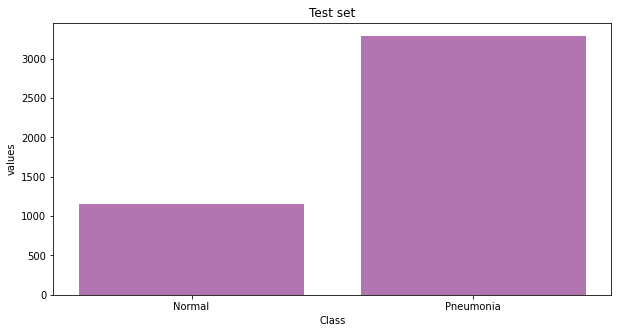

In [53]:
plt.figure(figsize=(10,5))

# create dataset
height = [Normal, Pneumonia]
bars = ('Normal', 'Pneumonia')

 
# Create bars and choose color
plt.bar(bars, height, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Test set')
plt.xlabel('Class')
plt.ylabel('values')
 
# Show graph
plt.show()

The dataset is imbalanced and thus we are going to treat this problem by changing the weights 

In [56]:
weight_Normal = (1 / Normal)*(4173)/2.0 
weight_Pneumonia = (1 / Pneumonia)*(4173)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for Normal: {:.2f}'.format(weight_Normal))
print('Weight for Pneumonia: {:.2f}'.format(weight_Pneumonia))

Weight for Normal: 1.80
Weight for Pneumonia: 0.63


In [57]:
# Model Creation 

def CNN():
    model = tf.keras.Sequential([
    
        # first convolutional layer 
        tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding = 'same', activation='relu', input_shape = [256,256,1]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        
        
        # second convolutional layer 
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding = 'same', activation='relu'), # same padding is equal to zero padding
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        
        # Droupout 
        tf.keras.layers.Dropout(0.2),
 
        # third convolutional layer 
        tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding = 'same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),        
        
        
        # fourth convolutional layer 
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding = 'same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),         
        
        
        # fifth convolutional layer 
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding = 'same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),  
        
        
        # sixth convolutional layer 
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding = 'same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),  
        
        # seventh convolutional layer 
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding = 'same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),  
        
        # eighth convolutional layer 
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding = 'same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),  
        
        
        # Droupout 
        tf.keras.layers.Dropout(0.2),
        
        # fully connected layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
      ])
    
       # compile the model 
    model.compile(optimizer = tf.keras.optimizers.RMSprop() , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    
    return model

In [58]:
model = CNN()

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0

In [60]:
# Callbacks 

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.2, min_lr=0.00001)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.h5",save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7,restore_best_weights=True)


In [64]:
history = model.fit(
    train_data_gen,
    batch_size = 32,
    epochs = 100 , 
    validation_data = val_data_gen,
    class_weight = class_weight,
    callbacks = [learning_rate_reduction, checkpoint_cb, early_stopping_cb])

Epoch 1/100
131/131 [==============================] - 44s 238ms/step - loss: 0.3642 - accuracy: 0.8205 - val_loss: 6.4806 - val_accuracy: 0.7430
Epoch 2/100
131/131 [==============================] - 33s 254ms/step - loss: 0.3038 - accuracy: 0.8802 - val_loss: 6.6851 - val_accuracy: 0.7430
Epoch 3/100
131/131 [==============================] - 33s 252ms/step - loss: 0.2548 - accuracy: 0.9027 - val_loss: 5.2890 - val_accuracy: 0.7430

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/100
131/131 [==============================] - 33s 254ms/step - loss: 0.1939 - accuracy: 0.9363 - val_loss: 2.3607 - val_accuracy: 0.7430
Epoch 5/100
131/131 [==============================] - 34s 258ms/step - loss: 0.1556 - accuracy: 0.9480 - val_loss: 0.5333 - val_accuracy: 0.7718
Epoch 6/100
131/131 [==============================] - 33s 253ms/step - loss: 0.1455 - accuracy: 0.9516 - val_loss: 0.1654 - val_accuracy: 0.9358
Epoch 7/100
131/131 [=====================

### Plot the results 

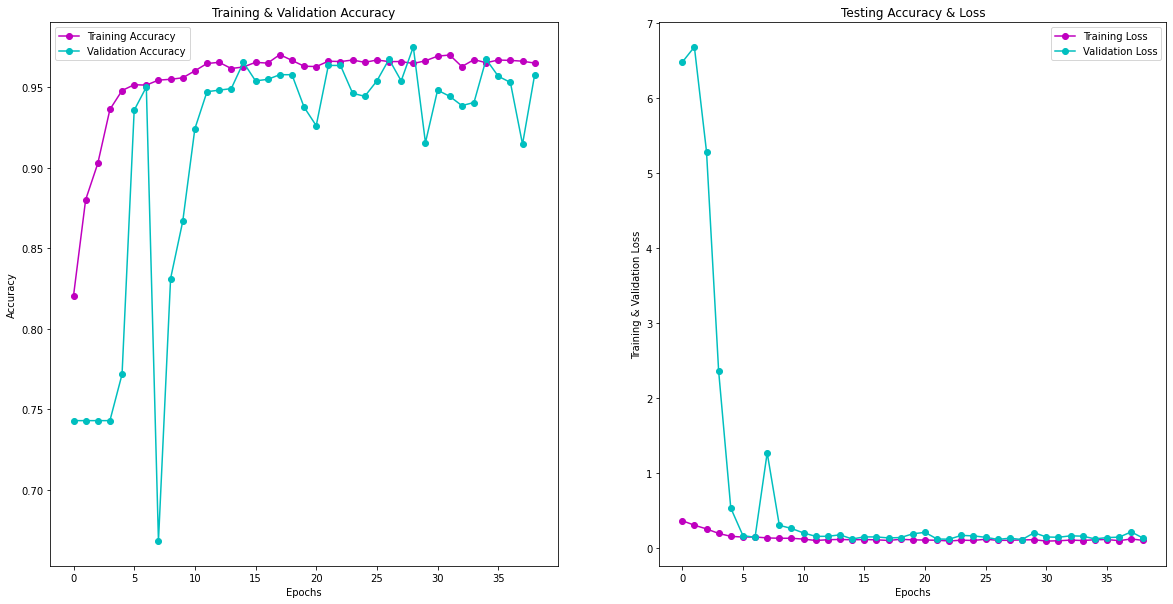

In [66]:
epochs = [i for i in range(39)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'mo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'co-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs , train_loss , 'm-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'c-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")


plt.show()

In [76]:
 test_loss , test_accuracy = model.evaluate(test_data_gen)

20/20 [==============================] - 2s 82ms/step - loss: 0.3019 - accuracy: 0.8830


In [92]:
# Make predictions 
predictions = model.predict_classes(test_data_gen)

predictions = predictions.reshape(1,-1)[0]


y_test = test_data_gen.classes


print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))



C:\Users\Tsaro\anaconda3\envs\tf_gpu2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.82      0.89      0.85       234
   Normal (Class 1)       0.93      0.88      0.90       390

           accuracy                           0.88       624
          macro avg       0.87      0.88      0.88       624
       weighted avg       0.89      0.88      0.88       624



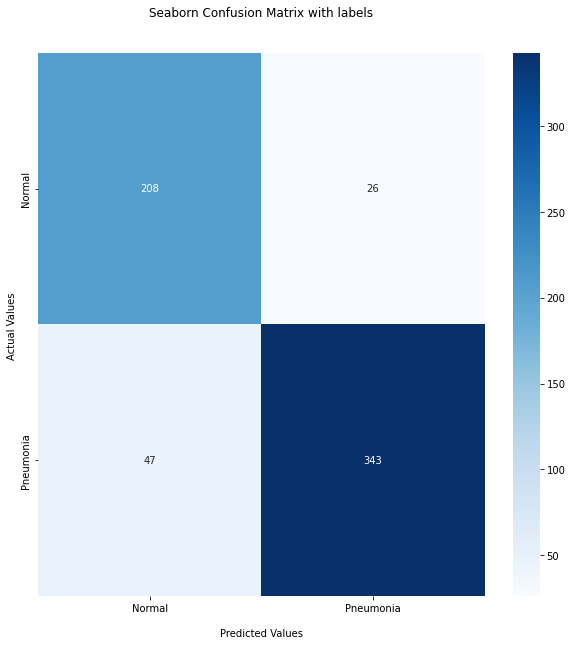

In [98]:
plt.figure(figsize = (10,10))

cm = confusion_matrix(y_test,predictions)

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [100]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Recall of the model is 0.88
Precision of the model is 0.93
F1 Score of the model is 0.90
